# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum"

nb_devices_for_the_run = 10
MAX_NB_DEVICES = 10

# Data preparation

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/quantum/phy_train.csv', sep="\t", header = None)
data = data.rename(columns={ 0: "ID", 1: "state", 5: "pivot1", 7: "pivot2", 67: "pivot3", 80: "nothing" })
data = data.drop(['ID', 'nothing'], axis=1)
data.head()

,state,2,3,4,pivot1,6,pivot2,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [3]:
dim_notebook = len(data.columns) - 1 # We don't count as dimension the labels
print("There is " + str(dim_notebook) + " dimensions.")

There is 78 dimensions.


In [4]:
# Showing that there is empty columns (with null std).
small_std = []
std_data = data.std()
for i in range(78):
    if std_data.iloc[i] < 1e-5:
        small_std.append(i)
print(small_std)
data.iloc[:,small_std].describe()

[47, 48, 49, 50, 51]


,48,49,50,51,52
count,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [5]:
# Removing columns with null std
data = data.loc[:, (data.std() > 1e-6)]
dim_notebook = len(data.columns) - 1
print("Now, there is " + str(dim_notebook) + " dimensions.")

Now, there is 73 dimensions.


In [6]:
#Showing that there is missing values ("999" and "9999" are used to denote a "not available" value).
number_of_missing_value = 0
for (columnName, columnData) in data.iteritems():
    if (999 in columnData) or (9999 in columnData):
        number_of_missing_value+=1

if number_of_missing_value != 0:
    print("There is missing value :", number_of_missing_value)
else:
    print("No missing value. Great !")

There is missing value : 74


In [7]:
#Removing missing values
for col in data.columns:
    data = data[data[col] != 999]
    data = data[data[col] != 9999]

In [8]:
#Cheking that ther is no more missing value
number_of_missing_value = 0
for (columnName, columnData) in data.iteritems():
    if (999 in columnData) or (9999 in columnData):
        print(columnData.values)
        number_of_missing_value+=1

if number_of_missing_value != 0:
    print("There is missing value :", number_of_missing_value)
else:
    print("No missing value. Great !")

No missing value. Great !


In [9]:
data = data.replace({'state': {0: -1}})
data.head()

,state,2,3,4,pivot1,6,pivot2,8,9,10,...,70,71,72,73,74,75,76,77,78,79
13,1,1.825530,0.654386,-0.768095,1.0,0.0,0.0,0.0,0.0,1.189447,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
21,-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.146006,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
38,-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.640898,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
40,-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.880948,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
42,1,0.406269,0.289490,-0.724766,-1.0,0.0,0.0,0.0,0.0,1.259992,...,0.0,0.0,0.0,0.406269,0.28949,-0.724766,-1.0,1.0,0.010939,0.957703


In [10]:
data['state'].value_counts()

-1    3162
 1    3035
Name: state, dtype: int64

In [11]:
#Separing features and labels
X_data = data.loc[:, data.columns != "state"]
Y_data = data.loc[:, data.columns == "state"]

#Data normalisation
X_scaled = scale(X_data)
Y_scaled = Y_data

In [12]:
with pd.option_context('display.max_columns', 80):
    print(data.describe(include='all'))

             state            2            3            4       pivot1  \
count  6197.000000  6197.000000  6197.000000  6197.000000  6197.000000   
mean     -0.020494     0.221729     0.116963    -0.046649    -0.001614   
std       0.999871     0.486564     0.352548     0.283658     0.455223   
min      -1.000000     0.000000     0.000000    -0.999665    -1.000000   
25%      -1.000000     0.000000     0.000000     0.000000     0.000000   
50%      -1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     2.260375     3.064190     0.999954     1.000000   

                 6       pivot2            8            9           10  \
count  6197.000000  6197.000000  6197.000000  6197.000000  6197.000000   
mean      0.184512     0.076006    -0.039148     0.002743     1.019385   
std       0.475267     0.285816     0.239645     0.386788     0.434046   
min       0.000000     0.000000    -1

## Handling IID data

In [13]:
#Transforming into torch.FloatTensor
X_merged = torch.tensor(X_scaled, dtype=torch.float64)
Y_merged = torch.tensor(Y_scaled.values, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")

# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
dim_notebook = X[0].shape[1]
for x in X:
    print("Number of points on this device:", len(x))

Number of points by devices:  619
There is 10 devices.
Number of points on this device: 619
Number of points on this device: 619
Number of points on this device: 619
Number of points on this device: 619
Number of points on this device: 619
Number of points on this device: 619
Number of points on this device: 619
Number of points on this device: 619
Number of points on this device: 619
Number of points on this device: 619


In [14]:
# Checking that data is balanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.4927302100161551
ratio of state 1 on this device:  0.5201938610662359
ratio of state 1 on this device:  0.4862681744749596
ratio of state 1 on this device:  0.47495961227786754
ratio of state 1 on this device:  0.5169628432956381
ratio of state 1 on this device:  0.43295638126009695
ratio of state 1 on this device:  0.505654281098546
ratio of state 1 on this device:  0.505654281098546
ratio of state 1 on this device:  0.4862681744749596
ratio of state 1 on this device:  0.4781906300484653


In [15]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=LogisticModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-iid-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

Large dimension...
   it    |   obj   
    4000 | 4.4503e-01
    8000 | 4.4503e-01
   12000 | 4.4503e-01
   16000 | 4.4503e-01


100%|██████████| 1/1 [08:54<00:00, 534.17s/it]

Gradient Descent: execution time=534.135 seconds
Final loss :  0.4450268212275933

CPU times: user 44min 52s, sys: 8min 20s, total: 53min 13s
Wall time: 8min 54s


In [16]:
id = 5
x = X[id]
w = obj_min_by_N_descent.model_params[-1]
mul = x.mv(w)
inf_middle = 0
failure = 0
for i in range(len(mul)):
    if torch.sigmoid(mul[i]) > 0.5:
        if Y[id][i] != 1:
            failure +=1
        inf_middle +=1
print("Number of labels equal to 1: ", inf_middle)
print("Failures:", failure)
print("Percent of labels wrongly predicted to be state 1: " + str(failure/inf_middle) + "%")

Number of labels equal to 1:  265
Failures: 64
Percent of labels wrongly predicted to be state 1: 0.24150943396226415%


In [17]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = LogisticModel(), 
                                               use_averaging=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-iid-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...


 20%|██        | 1/5 [02:08<08:35, 128.77s/it]

QSGD
Large dimension...
Large dimension...


 40%|████      | 2/5 [06:17<08:14, 164.83s/it]

Diana
Large dimension...
Large dimension...


 60%|██████    | 3/5 [10:24<06:19, 189.52s/it]

BiQSGD
Large dimension...
Large dimension...


 80%|████████  | 4/5 [14:51<03:32, 212.77s/it]

Artemis
Large dimension...
Large dimension...


100%|██████████| 5/5 [19:07<00:00, 229.55s/it]

CPU times: user 36min 9s, sys: 2min 1s, total: 38min 10s
Wall time: 19min 7s


In [18]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-0.0587, -0.0507,  0.0764,  0.0145,  0.6726, -0.0160, -0.0044, -0.0375,
         0.2078,  0.0490, -0.0200,  0.0211, -0.0716,  1.1083,  0.6675,  0.1598,
         0.0173,  0.0162, -0.0045,  0.0300,  0.6375, -0.0494,  0.0347, -0.0574,
        -0.0205, -0.0345, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068,
        -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068,
        -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068,
        -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068,
        -0.0068, -0.0068, -0.0068, -0.0219,  0.0532,  0.0127,  0.0332, -0.0068,
        -0.0068, -0.0068, -0.0068, -0.1113, -0.0777, -0.0228, -0.6069,  0.1190,
         0.0460, -0.0040], dtype=torch.float64)


# With averaging

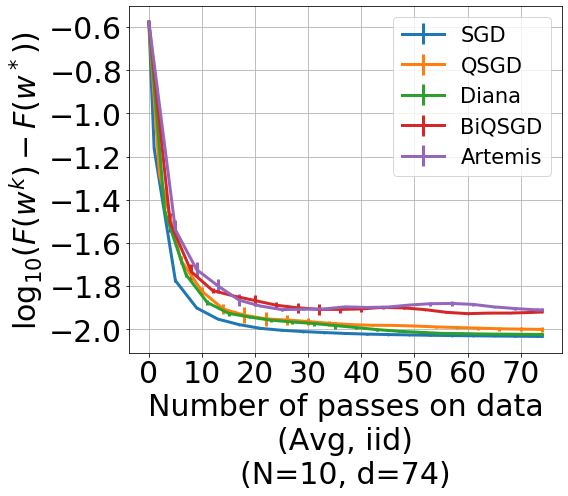

In [19]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")
obj = obj_min_by_N[len(myX)] - 0.009

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data\n(Avg, iid)") 

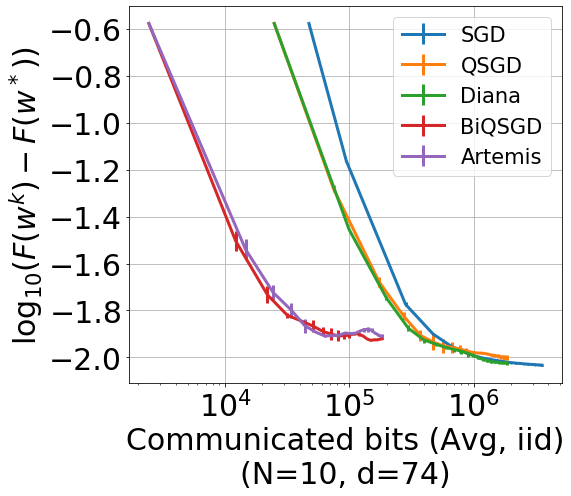

In [20]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, iid)") 


# Without averaging

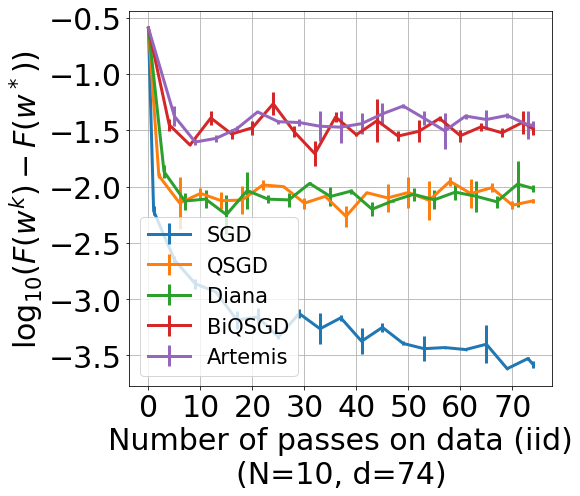

In [21]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_legend="Number of passes on data (iid)", all_error=res.get_std(obj)) 

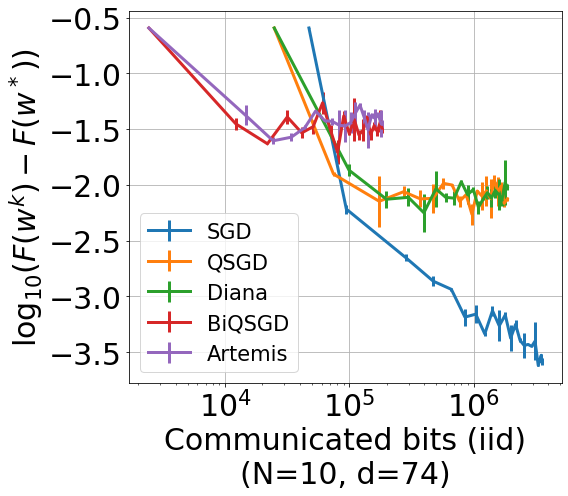

In [22]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (iid)", all_error=res.get_std(obj)) 

# Handling non-iid data

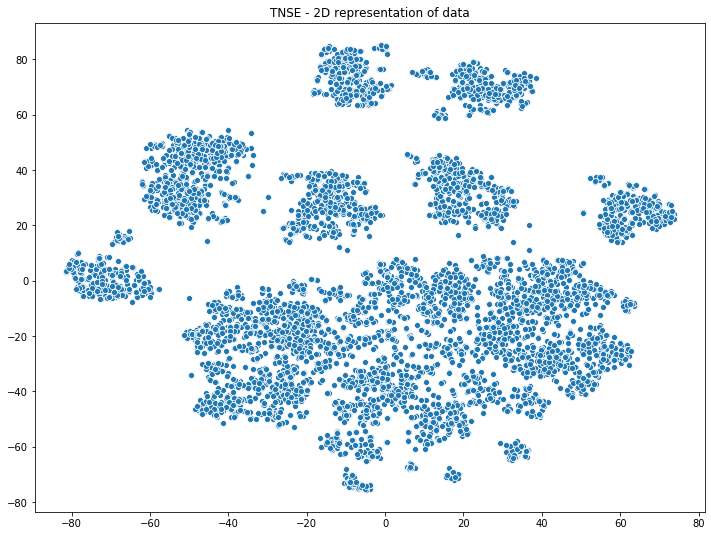

In [23]:
# Running TNSE to obtain a 2D representation of data
embedded_data = tnse(data)

There is 10 devices.
Number of points on device 0 : 866
Number of points on device 1 : 1015
Number of points on device 2 : 746
Number of points on device 3 : 320
Number of points on device 4 : 1008
Number of points on device 5 : 789
Number of points on device 6 : 407
Number of points on device 7 : 348
Number of points on device 8 : 297
Number of points on device 9 : 401


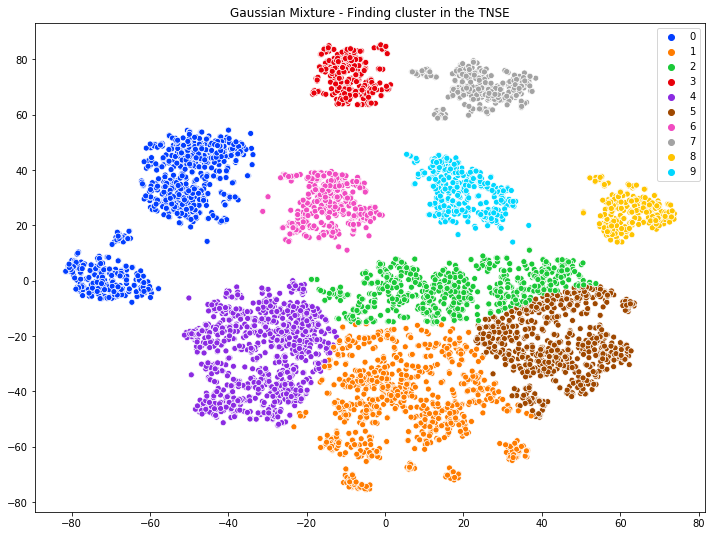

In [24]:
nb_cluster = 10
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "state", nb_cluster, scale_Y=False)
dim_notebook = X[0].shape[1]

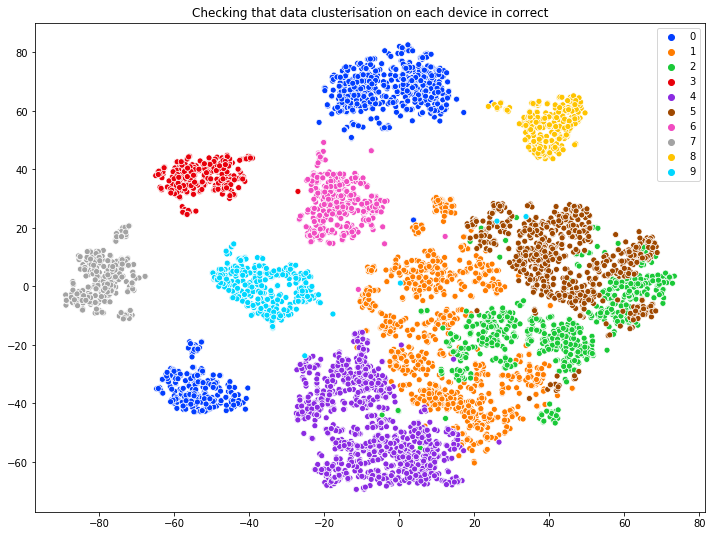

In [25]:
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [26]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.6374133949191686
ratio of state 1 on this device:  0.2650246305418719
ratio of state 1 on this device:  0.6474530831099196
ratio of state 1 on this device:  0.421875
ratio of state 1 on this device:  0.9523809523809523
ratio of state 1 on this device:  0.058301647655259824
ratio of state 1 on this device:  0.20884520884520885
ratio of state 1 on this device:  0.5574712643678161
ratio of state 1 on this device:  0.037037037037037035
ratio of state 1 on this device:  0.7481296758104738


In [27]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_cluster,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=LogisticModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
obj_min_by_N_descent.set_data(X,Y)
obj_min_by_N_descent.run()
obj_min_by_N[nb_cluster] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-noniid-obj_min")

Large dimension...
   it    |   obj   
    4000 | 4.0736e-01
    8000 | 4.0735e-01
   12000 | 4.0735e-01
   16000 | 4.0735e-01
Gradient Descent: execution time=133.065 seconds
Final loss :  0.40735471506074755

CPU times: user 22min 5s, sys: 2min 11s, total: 24min 16s
Wall time: 2min 13s


In [22]:
%%time
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, X, Y, model = LogisticModel(), 
                                               use_averaging=True, stochastic=False, nb_epoch=400)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

QSGD
Large dimension...
Large dimension...


 40%|████      | 2/5 [00:06<00:09,  3.12s/it]

Diana
Large dimension...
Large dimension...


 60%|██████    | 3/5 [00:10<00:06,  3.34s/it]

BiQSGD
Large dimension...
Large dimension...


 80%|████████  | 4/5 [00:14<00:03,  3.53s/it]

Artemis
Large dimension...
Large dimension...


100%|██████████| 5/5 [00:18<00:00,  3.69s/it]

CPU times: user 1min 13s, sys: 648 ms, total: 1min 14s
Wall time: 18.5 s


## With averaging

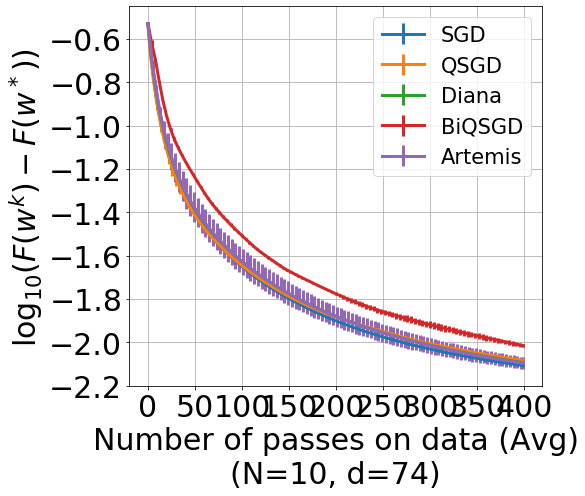

In [23]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data (Avg)") 

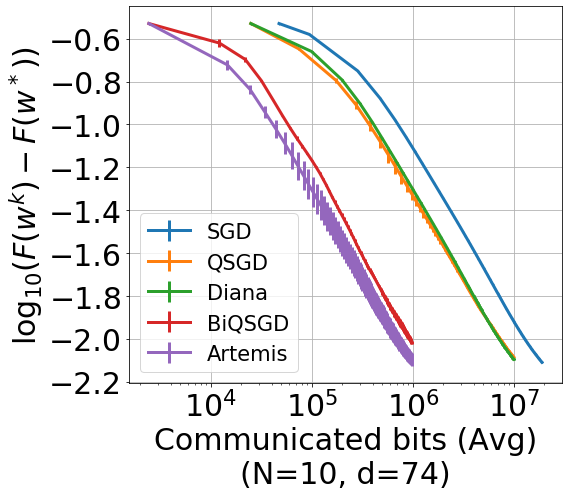

In [27]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


## Without averaging

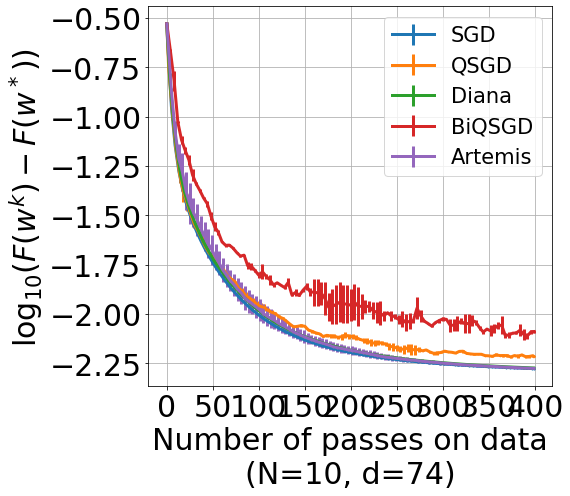

In [28]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 

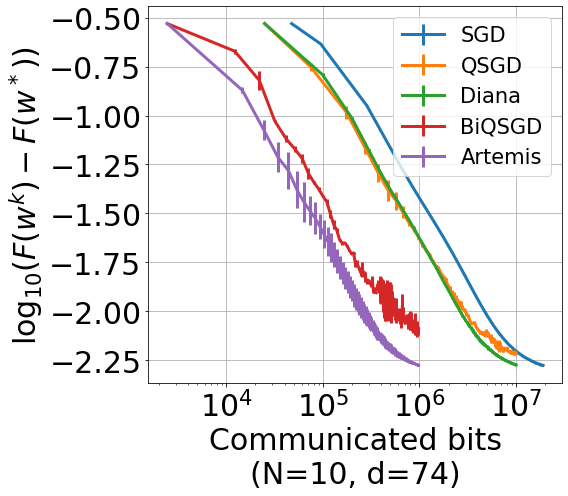

In [26]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 